In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder, PowerTransformer, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import ElasticNet
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from math import sqrt


In [3]:
bike_data_raw = pd.read_csv('daily-bike-share.csv')
bike_data_raw['dteday'] = pd.to_datetime(bike_data_raw['dteday'])

In [4]:
bike_data = bike_data_raw.copy()
bike_data.drop(['instant', 'dteday', 'yr'], axis=1, inplace=True)
bike_data['difference_temp'] = (bike_data['atemp'] - bike_data['temp']) / bike_data['temp']
bike_data.drop(['atemp'], axis=1, inplace=True)

numeric_features = ['temp', 'difference_temp', 'hum', 'windspeed']
categorical_features = ['season', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit']
target = 'rentals'

In [5]:
X = bike_data[numeric_features + categorical_features].copy()
y = bike_data[target].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

numeric_transformer = Pipeline(steps=[
    ('logtransformer', PowerTransformer()),
    ('standardscaler', StandardScaler()),
    ('polynomialfeatures', PolynomialFeatures(degree=2)) 
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

final_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', ElasticNet(alpha=0.1, l1_ratio=0.5))  
])


In [6]:
final_pipeline.fit(X_train, y_train)

predictions = final_pipeline.predict(X_test)

Final Model Train R^2: 0.7275583268084231
Final Model Test R^2: 0.5697818699381703
Final Model Train MAE: 251.72792017998012
Final Model Test MAE: 330.3739477159528
Final Model Train MAPE: 0.8145828215194222
Final Model Test MAPE: 1.1292341455768775
Final Model Train MSE: 124768.76641776464
Final Model Test MSE: 211974.53376187646
Final Model Train RMSE: 353.22622555207397
Final Model Test RMSE: 460.4069219308898


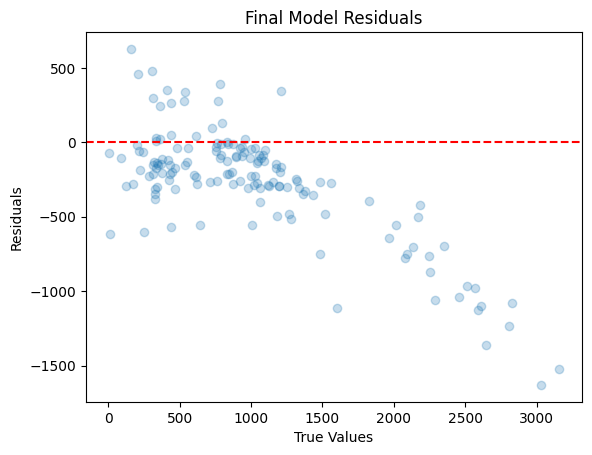

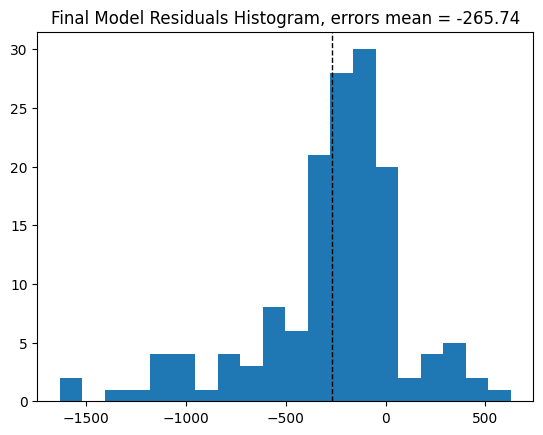

In [7]:
final_r2_train = r2_score(y_train, final_pipeline.predict(X_train))
final_r2_test = r2_score(y_test, predictions)
final_mae_train = mean_absolute_error(y_train, final_pipeline.predict(X_train))
final_mae_test = mean_absolute_error(y_test, predictions)
final_mape_train = mean_absolute_percentage_error(y_train, final_pipeline.predict(X_train))
final_mape_test = mean_absolute_percentage_error(y_test, predictions)
final_mse_train = mean_squared_error(y_train, final_pipeline.predict(X_train))
final_mse_test = mean_squared_error(y_test, predictions)
final_rmse_train = sqrt(final_mse_train)
final_rmse_test = sqrt(final_mse_test)

print(f'Final Model Train R^2: {final_r2_train}')
print(f'Final Model Test R^2: {final_r2_test}')
print(f'Final Model Train MAE: {final_mae_train}')
print(f'Final Model Test MAE: {final_mae_test}')
print(f'Final Model Train MAPE: {final_mape_train}')
print(f'Final Model Test MAPE: {final_mape_test}')
print(f'Final Model Train MSE: {final_mse_train}')
print(f'Final Model Test MSE: {final_mse_test}')
print(f'Final Model Train RMSE: {final_rmse_train}')
print(f'Final Model Test RMSE: {final_rmse_test}')

final_errors = predictions - y_test
plt.scatter(x=y_test, y=final_errors, alpha=0.25)
plt.axhline(0, color="r", linestyle="--")
plt.xlabel('True Values')
plt.ylabel('Residuals')
plt.title('Final Model Residuals')
plt.show()

plt.hist(final_errors, bins=20)
plt.axvline(final_errors.mean(), color='k', linestyle='dashed', linewidth=1)
plt.title(f'Final Model Residuals Histogram, errors mean = {np.round(final_errors.mean(), 2)}')
plt.show()

## Podsumowanie

| Metryka               | Pierwszy model - Train | Pierwszy model - Test | Model nr 2 - Train | Model nr 2 - Test | Model nr 3 - Train | Model nr 3 - Test | Wnioski |
|-----------------------|------------------------|-----------------------|--------------------------|-------------------------|---------------------------|--------------------------|---------------|
| **R^2**               | 0.3062                 | 0.1941                | 0.7011                   | 0.5247                  | 0.7276                    | 0.5698 |  Drugi model lepiej dopasowuje dane treningowe. Drugi model osiąga lepsze dopasowanie na danych testowych.                     |
| **MAE**               | 404.83                 | 391.03                | 261.30                   | 348.59                  | 251.73                    | 330.37 | Drugi model jest bardziej precyzyjny na danych treningowych. Drugi model ma mniejsze błędy bezwzględne na danych testowych.            |
| **MAPE**              | 0.9669                 | 2.9865                | 0.7443                   | 0.8593                  | 0.8146                    | 1.1292 | Finalny model lepiej sobie radzi w zakresie błędów procentowych na danych treningowych. Finalny model jest bardziej precyzyjny w zakresie błędów procentowych na danych testowych.                  |
| **MSE**               | 317745.94              | 397066.94             | 136897.75                | 234195.93               | 124768.77                 | 211974.53 | Drugi model ma mniejsze błędy kwadratowe na danych testowych. Drugi model lepiej minimalizuje błąd kwadratowy na danych treningowych.               |
| **RMSE**              | 563.69                 | 630.13                | 369.99                   | 483.94                  | 353.23                    | 460.41 | Drugi model jest nieco bardziej stabilny na danych treningowych.  Pierwszy model ma mniejsze odchylenie błędów na danych testowych.                |       


## Który model jest lepszy? 
Model nr 2 jest lepszy pod względem większości metryk (R^2, MAE, MSE, RMSE), co oznacza, że jest bardziej dokładny w przewidywaniu liczby wypożyczeń.
